

# Ridge Regression and the Lasso

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

We will use the `sklearn` package in order to perform ridge regression and
the lasso. The main functions in this package that we care about are `Ridge()`, which can be used
to fit ridge regression models, and `Lasso()` which will fit lasso models. They also have cross-validated counterparts: `RidgeCV()` and `LassoCV()`. We'll use these a bit later.

Before proceeding, let's first ensure that the missing values have
been removed from the data, as described in the previous lab.

In [2]:
df = pd.read_csv('Hitters.csv')
df = pd.read_csv('Hitters.csv').dropna().drop(df.columns[0], axis = 1)
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


We will now perform ridge regression and the lasso in order to predict `Salary` on
the `Hitters` data. Let's set up our data:

In [3]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis = 1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  League_N     263 non-null    uint8  
 17  Division_W   263 non-null    uint8  
 18  NewLeague_N  263 non-null    uint8  
dtypes: float

# Ridge Regression
The `Ridge()` function has an alpha argument ($\lambda$, but with a different name!) that is used to tune the model. We'll generate an array of alpha values ranging from very big to very small, essentially
covering the full range of scenarios from the null model containing
only the intercept, to the least squares fit:

In [4]:
alphas = 10**np.linspace(10,-2,100)*0.5
alphas

array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+07, 1.07721735e+07, 8.14875417e+06,
       6.16423370e+06, 4.66301673e+06, 3.52740116e+06, 2.66834962e+06,
       2.01850863e+06, 1.52692775e+06, 1.15506485e+06, 8.73764200e+05,
       6.60970574e+05, 5.00000000e+05, 3.78231664e+05, 2.86118383e+05,
       2.16438064e+05, 1.63727458e+05, 1.23853818e+05, 9.36908711e+04,
       7.08737081e+04, 5.36133611e+04, 4.05565415e+04, 3.06795364e+04,
       2.32079442e+04, 1.75559587e+04, 1.32804389e+04, 1.00461650e+04,
       7.59955541e+03, 5.74878498e+03, 4.34874501e+03, 3.28966612e+03,
       2.48851178e+03, 1.88246790e+03, 1.42401793e+03, 1.07721735e+03,
      

Associated with each alpha value is a vector of ridge regression coefficients, which we'll
store in a matrix `coefs`. In this case, it is a $19 \times 100$
matrix, with 19 rows (one for each predictor) and 100
columns (one for each value of alpha). Remember that we'll want to standardize the
variables so that they are on the same scale. To do this, we can use the
`normalize = True` parameter! No we can't because it is DEPRECATED:

In [5]:
#ridge = Ridge() # normalize parameter deprecated. Using make_pipeline(StandardScaler(with_mean=False) is suggested

ridge = make_pipeline(StandardScaler(), Ridge())
coefs = []

for alpha in alphas:
    ridge.named_steps['ridge'].set_params(alpha=alpha)  # Set alpha on the Ridge estimator
    ridge.fit(X, y)
    coefs.append(ridge.named_steps['ridge'].coef_)
    
np.shape(coefs)

(100, 19)

We expect the coefficient estimates to be much smaller, in terms of $l_2$ norm,
when a large value of alpha is used, as compared to when a small value of alpha is
used. Let's plot and find out:

Text(0, 0.5, 'weights')

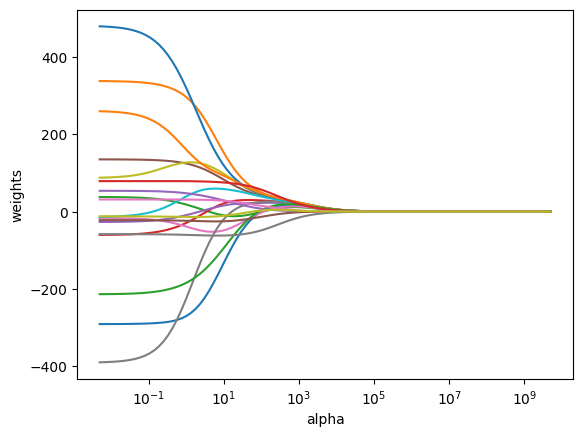

In [6]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

We now split the samples into a training set and a test set in order
to estimate the test error of ridge regression and the lasso:

In [7]:
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

Next we fit a ridge regression model on the training set, and evaluate
its MSE on the test set, using $\lambda = 4$:

In [8]:
# Create a pipeline with StandardScaler and Ridge with alpha=4
ridge2 = make_pipeline(StandardScaler(), Ridge(alpha=4))
ridge2.fit(X_train, y_train)  # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)  # Use this model to predict the test data

# Access and print the coefficients of the Ridge model
ridge2_coef = ridge2.named_steps['ridge'].coef_
coef_series = pd.Series(ridge2_coef, index=X.columns)
print(coef_series)

# Calculate the test MSE
mse = mean_squared_error(y_test, pred2)
print(mse)

AtBat         -210.807322
Hits           193.076932
HmRun          -51.437368
Runs             1.624070
RBI             81.458917
Walks           94.582539
Years          -28.029476
CAtBat        -117.924364
CHits           91.159632
CHmRun          91.762010
CRuns          101.115450
CRBI           117.598963
CWalks         -38.434685
PutOuts        125.556071
Assists         25.559188
Errors         -18.518904
League_N        35.792050
Division_W     -60.245442
NewLeague_N    -18.650623
dtype: float64
102144.52395076488


The test MSE when alpha = 4 is 102144.52. Now let's see what happens if we use a huge value of alpha, say $10^{10}$:

In [9]:
# Create a pipeline with StandardScaler and Ridge with alpha=10^10
ridge3 = make_pipeline(StandardScaler(), Ridge(alpha = 10**10))
ridge3.fit(X_train, y_train)  # Fit a ridge regression on the training data
pred3 = ridge3.predict(X_test)  # Use this model to predict the test data

# Access and print the coefficients of the Ridge model
ridge3_coef = ridge3.named_steps['ridge'].coef_
coef_series = pd.Series(ridge3_coef, index=X.columns)
print(coef_series)

# Calculate the test MSE
mse = mean_squared_error(y_test, pred3)
print(mse)

AtBat          2.526133e-06
Hits           2.826091e-06
HmRun          2.174902e-06
Runs           2.632138e-06
RBI            3.183658e-06
Walks          2.941154e-06
Years          2.478179e-06
CAtBat         3.213788e-06
CHits          3.432349e-06
CHmRun         3.435819e-06
CRuns          3.522298e-06
CRBI           3.602930e-06
CWalks         3.216811e-06
PutOuts        2.851209e-06
Assists       -4.856786e-08
Errors         1.736624e-07
League_N      -1.637144e-07
Division_W    -1.015188e-06
NewLeague_N   -1.325154e-07
dtype: float64
172862.22059245987


This big penalty shrinks the coefficients to a very large degree, essentially reducing to a model containing just the intercept. This over-shrinking makes the model more biased, resulting in a higher MSE.

Okay, so fitting a ridge regression model with alpha = 4 leads to a much lower test
MSE than fitting a model with just an intercept. We now check whether
there is any benefit to performing ridge regression with alpha = 4 instead of
just performing least squares regression. Recall that least squares is simply
ridge regression with alpha = 0.

In [10]:
# Create a pipeline with StandardScaler and Ridge with alpha=0
ridge2 = make_pipeline(StandardScaler(), Ridge(alpha = 0))
ridge2.fit(X_train, y_train)  # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)  # Use this model to predict the test data

# Access and print the coefficients of the Ridge model
ridge2_coef = ridge2.named_steps['ridge'].coef_
coef_series = pd.Series(ridge2_coef, index=X.columns)
print(coef_series)

# Calculate the test MSE
mse = mean_squared_error(y_test, pred2)
print(mse)

AtBat          -266.553048
Hits            197.706218
HmRun           -38.103182
Runs             -1.007996
RBI             103.119845
Walks            79.750209
Years            45.357697
CAtBat        -1399.811384
CHits          1426.954812
CHmRun          264.037977
CRuns            86.858781
CRBI           -211.142393
CWalks           42.533597
PutOuts         126.075563
Assists          65.816094
Errors          -38.313885
League_N         66.822855
Division_W      -56.870280
NewLeague_N     -40.962688
dtype: float64
116690.46856660831


It looks like we are indeed improving over regular least-squares!

Instead of arbitrarily choosing alpha $ = 4$, it would be better to
use cross-validation to choose the tuning parameter alpha. We can do this using
the cross-validated ridge regression function, `RidgeCV()`. By default, the function
performs generalized cross-validation (an efficient form of LOOCV), though this can be changed using the
argument `cv`.

In [11]:
# Create a pipeline with StandardScaler and RidgeCV
ridgecv = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, scoring='neg_mean_squared_error'))
ridgecv.fit(X_train, y_train)

# Access the chosen alpha value from RidgeCV
chosen_alpha = ridgecv.named_steps['ridgecv'].alpha_
print(chosen_alpha)

66.09705742330144


Therefore, we see that the value of alpha that results in the smallest cross-validation
error is 66. What is the test MSE associated with this value of
alpha?

In [13]:
# Create a Ridge model using the chosen alpha from RidgeCV
ridge4 = Ridge(alpha=ridgecv.named_steps['ridgecv'].alpha_)
ridge4.fit(X_train, y_train)

# Calculate the test MSE using the trained Ridge model
mse = mean_squared_error(y_test, ridge4.predict(X_test))
print(mse)

117347.54036737498


This represents a further improvement over the test MSE that we got using
alpha $ = 4$. Finally, we refit our ridge regression model on the full data set,
using the value of alpha chosen by cross-validation, and examine the coefficient
estimates.

In [35]:
ridge4.fit(X, y)
pd.Series(ridge4.coef_, index = X.columns)

AtBat          -2.099264
Hits            7.652642
HmRun           3.175174
Runs           -2.151817
RBI            -0.484978
Walks           6.124221
Years          -2.545847
CAtBat         -0.174975
CHits           0.090914
CHmRun         -0.207909
CRuns           1.550308
CRBI            0.809434
CWalks         -0.800345
PutOuts         0.288107
Assists         0.378553
Errors         -3.045655
League_N       17.652525
Division_W    -56.395049
NewLeague_N     7.744048
dtype: float64

As expected, none of the coefficients are exactly zero - ridge regression does not
perform variable selection!

# The Lasso
We saw that ridge regression with a wise choice of alpha can outperform least
squares as well as the null model on the Hitters data set. We now ask
whether the lasso can yield either a more accurate or a more interpretable
model than ridge regression. In order to fit a lasso model, we'll
use the `Lasso()` function; however, this time we'll need to include the argument `max_iter = 10000`.
Other than that change, we proceed just as we did in fitting a ridge model:

Text(0, 0.5, 'weights')

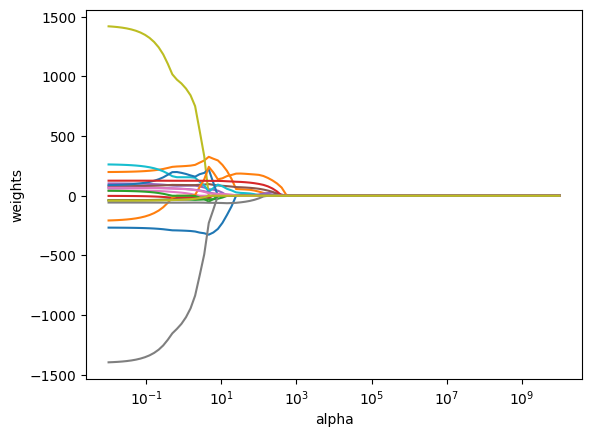

In [14]:
lasso = Lasso(max_iter = 10000) # Standard scale pipeline will fix!
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

Notice that in the coefficient plot that depending on the choice of tuning
parameter, some of the coefficients are exactly equal to zero. We now
perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [15]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

118255.15053121907

This is substantially lower than the test set MSE of the null model and of
least squares, and only a little worse than the test MSE of ridge regression with alpha
chosen by cross-validation.

However, the lasso has a substantial advantage over ridge regression in
that the resulting coefficient estimates are sparse. Here we see that 13 of
the 19 coefficient estimates are exactly zero:

In [16]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat          0.186425
Hits           0.000000
HmRun          0.000000
Runs           0.000000
RBI            0.000000
Walks          0.000000
Years         -0.000000
CAtBat        -0.508102
CHits          1.424662
CHmRun         0.000000
CRuns          0.597670
CRBI           0.548273
CWalks         0.404799
PutOuts        0.456655
Assists        0.048838
Errors        -0.000000
League_N       0.000000
Division_W    -0.000000
NewLeague_N    0.000000
dtype: float64